In [2]:
import pandas as pd
import numpy as pn
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import plotly.express as px
from fredapi import Fred
pd.options.display.max_rows = 200
pd.options.display.max_columns = 500
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
fred_key = 'Hahaha I am not giving you my key, get your own key at https://fred.stlouisfed.org/, it is free'

In [4]:
fred = Fred(api_key=fred_key)

In [5]:
sp_search = fred.search('S&P', order_by='popularity')


In [6]:
sp_search.head()

,id,realtime_start,realtime_end,title,observation_start,observation_end,frequency,frequency_short,units,units_short,seasonal_adjustment,seasonal_adjustment_short,last_updated,popularity,notes
series id,,,,,,,,,,,,,,,
BAMLH0A0HYM2,BAMLH0A0HYM2,2024-08-21,2024-08-21,ICE BofA US High Yield Index Option-Adjusted S...,1996-12-31,2024-08-20,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-08-21 09:18:14-05:00,92,The ICE BofA Option-Adjusted Spreads (OASs) ar...
CSUSHPINSA,CSUSHPINSA,2024-08-21,2024-08-21,S&P CoreLogic Case-Shiller U.S. National Home ...,1987-01-01,2024-05-01,Monthly,M,Index Jan 2000=100,Index Jan 2000=100,Not Seasonally Adjusted,NSA,2024-07-30 08:11:01-05:00,88,"For more information regarding the index, plea..."
SP500,SP500,2024-08-21,2024-08-21,S&P 500,2014-08-21,2024-08-20,"Daily, Close",D,Index,Index,Not Seasonally Adjusted,NSA,2024-08-20 19:12:27-05:00,83,The observations for the S&P 500 represent the...
MEHOINUSA672N,MEHOINUSA672N,2024-08-21,2024-08-21,Real Median Household Income in the United States,1984-01-01,2022-01-01,Annual,A,2022 CPI-U-RS Adjusted Dollars,2022 CPI-U-RS Adjusted $,Not Seasonally Adjusted,NSA,2023-09-12 13:48:02-05:00,83,Household data are collected as of March. As ...
BAMLH0A0HYM2EY,BAMLH0A0HYM2EY,2024-08-21,2024-08-21,ICE BofA US High Yield Index Effective Yield,1996-12-31,2024-08-20,"Daily, Close",D,Percent,%,Not Seasonally Adjusted,NSA,2024-08-21 09:18:17-05:00,82,This data represents the effective yield of th...


<Axes: title={'center': 'S&P 500'}>

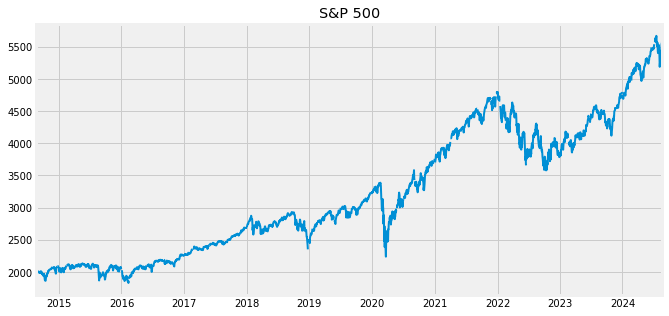

In [7]:
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title= 'S&P 500', lw=2)

In [8]:
unmp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unmp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]


In [9]:
#joining data
all_results2 = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results2.append(results)
    
unmp_results = pd.concat(all_results2, axis=1)


In [10]:
#Dropping non-states data
cols_to_drop = []
for i in unmp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
unmp_results = unmp_results.drop(columns = cols_to_drop, axis=1)

In [11]:
unmp_states = unmp_results.copy() 
unmp_states = unmp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
unmp_states.columns = [id_to_state[c] for c in unmp_states.columns]

In [12]:
#Unemployment rate by state
px.line(unmp_states)

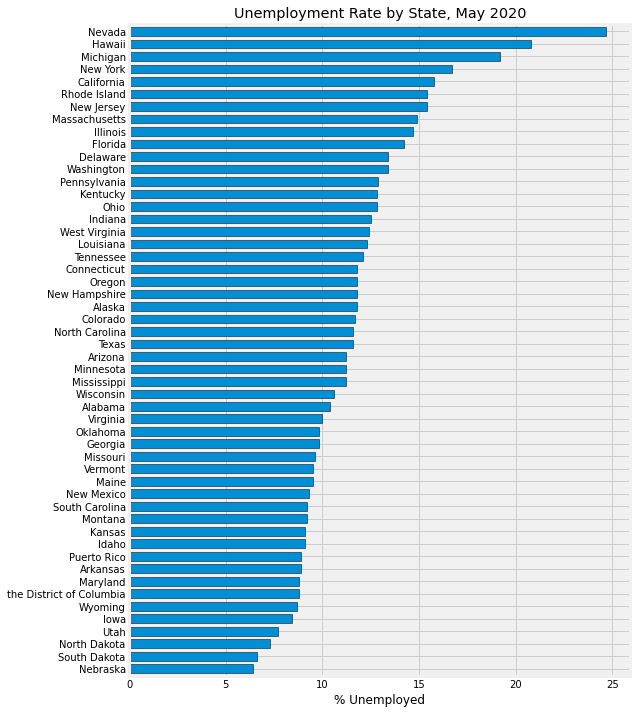

In [13]:
ax = unmp_states.loc[unmp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

In [16]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')

In [18]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [21]:
unmp_states = unmp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

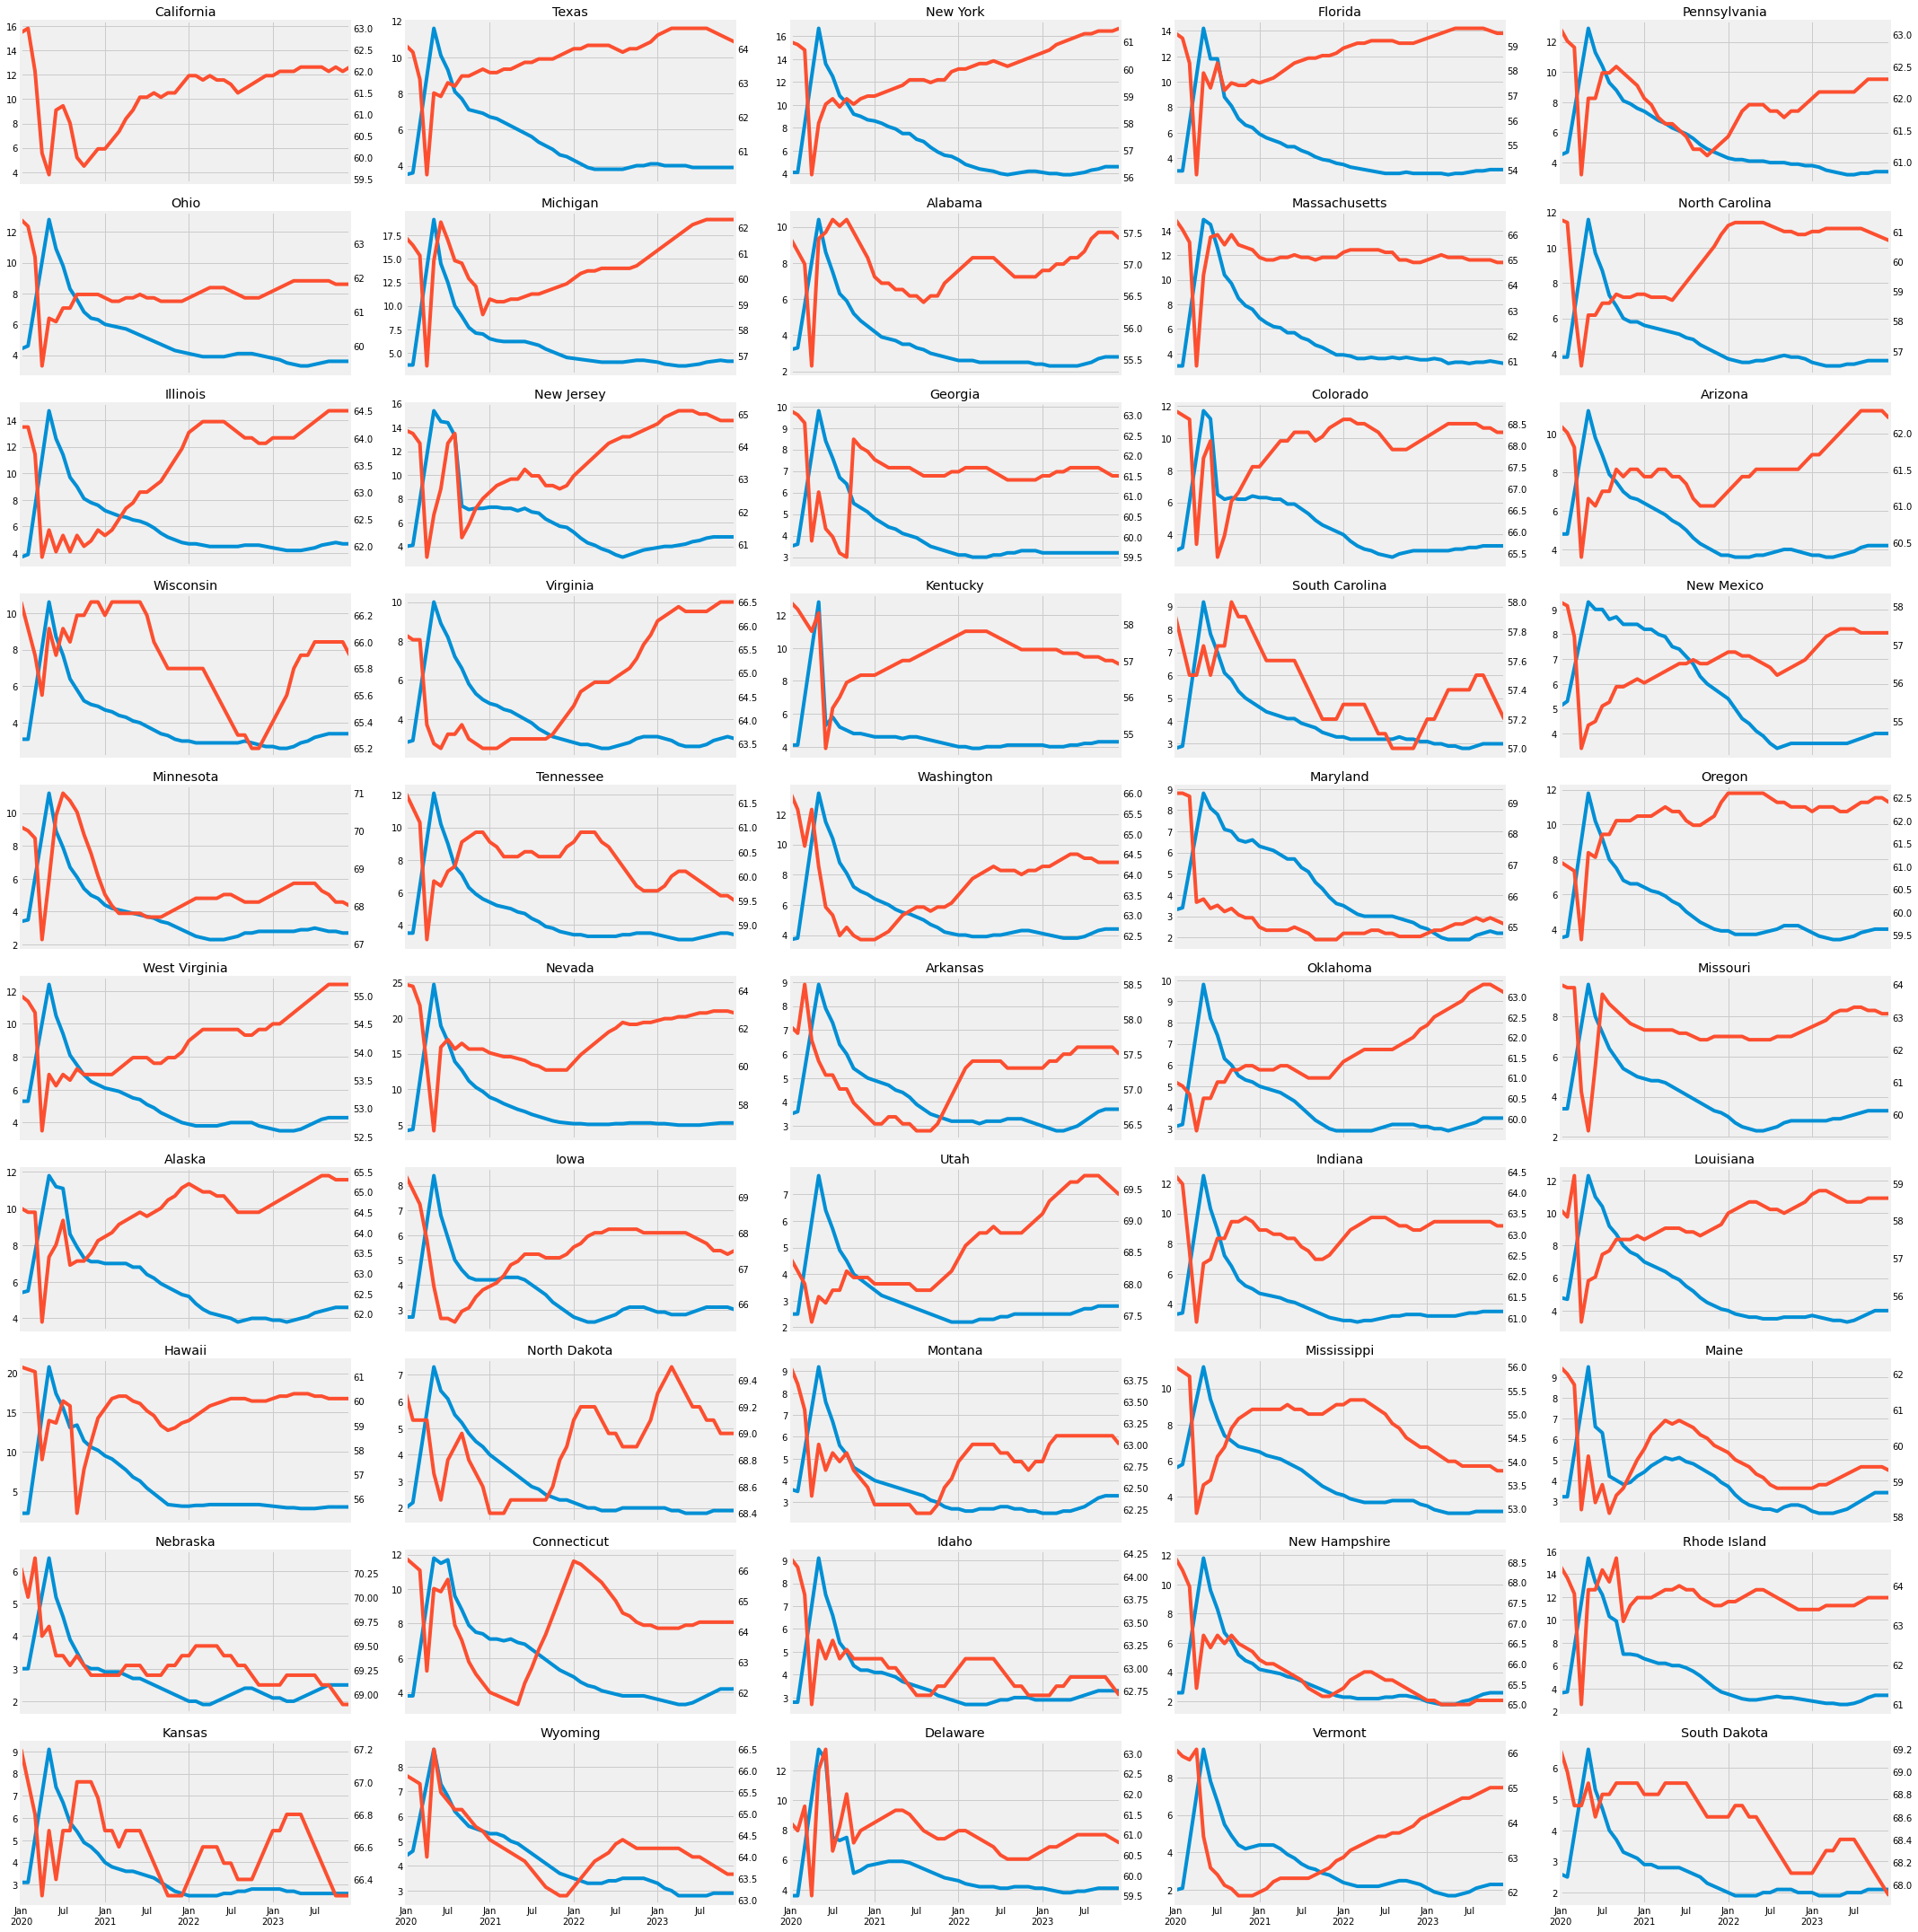

In [27]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in unmp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    unmp_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2024')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()

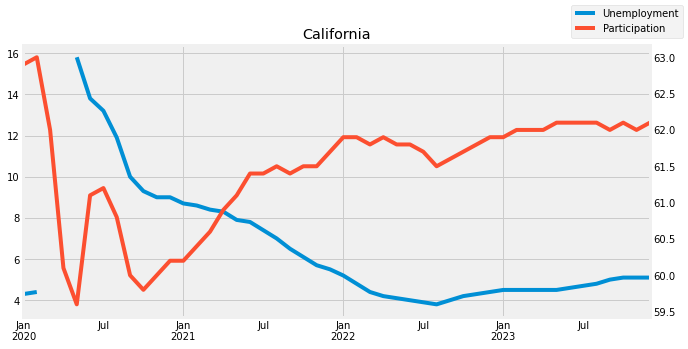

In [28]:
state = 'California'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True)
ax2 = ax.twinx()
uemp_states2 = unmp_states.asfreq('MS')
l1 = uemp_states2.query('index >= 2020 and index < 2024')[state] \
    .plot(ax=ax, label='Unemployment')
l2 = part_states.dropna().query('index >= 2020 and index < 2024')[state] \
    .plot(ax=ax2, label='Participation', color=color_pal[1])
ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()